/home/hardik/Desktop/Research/Safe-Learning-DASC/venv_sl_dasc/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


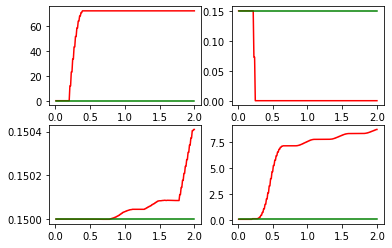

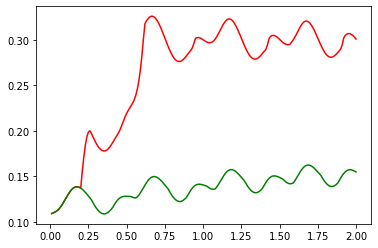

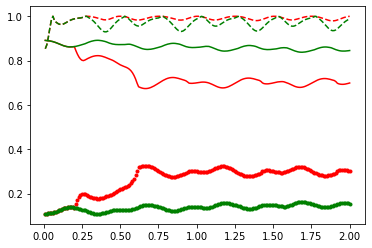

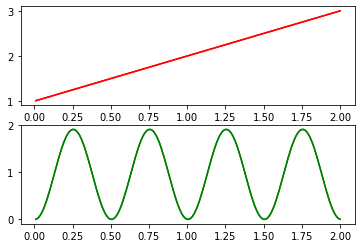

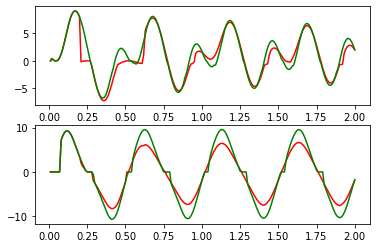

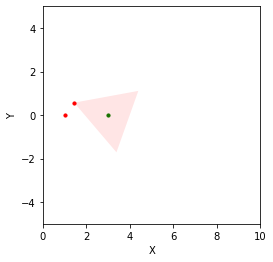

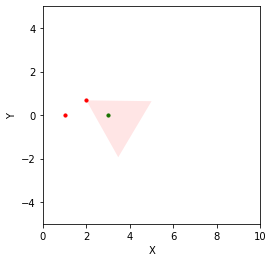

In [1]:
# SIngle Integrator example

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import os
import time
from numpy.core.numeric import _moveaxis_dispatcher

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

import matplotlib.cm as cm
import matplotlib.animation as animation

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import cvxpy as cp
import torch
from torch.cuda import max_memory_cached

from cvxpylayers.torch import CvxpyLayer

from robot_models.Unicycle2D import *
from robot_models.SingleIntegrator import *

from matplotlib.animation import FFMpegWriter

FoV = 60*np.pi/180
max_D = 3
min_D = 0.3

import signal
signal.signal(signal.SIGINT, signal.SIG_DFL)


def wrap_angle(angle):
    if angle>np.pi:
        angle = angle - 2*np.pi
    if angle<-np.pi:
        angle = angle + 2*np.pi
    return angle

def build_GP_model(N):
    GP_list = []
    noise = 0.01
    for i in range(N):
        kern = 1.0 * RBF(length_scale=2, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e+1))
        gp = GaussianProcessRegressor(kernel=kern, alpha = noise, n_restarts_optimizer=1)
        GP_list.append(gp)
    return GP_list

def filter_data(obs_x,obs_value,curr_x,thres=0.4):
    filter_x = []
    filter_value = []
    for index, t in enumerate(obs_x):
        if np.abs(t-curr_x)<thres:
            filter_x.append(t)
            filter_value.append(obs_value[index])
    return filter_x, filter_value

@ignore_warnings(category=UserWarning)
@ignore_warnings(category=ConvergenceWarning)
def update_GP_dynamics(GP_list,X,Y, index, curr_X):
    X, Y = filter_data(X,Y,curr_X)
    GP_list[index].fit(np.asarray(X).reshape(-1,1),np.asarray(Y).reshape(-1,1))

def predict_GP_dynamics(GP_list,N,X):
    Y = []
    Y_std = []
    for i in range(N):
        y_pred, sigma_pred = GP_list[i].predict(np.array([X]).reshape(-1, 1),return_std=True)
        # print(f"y:{y_pred[0]}, y_pred: {sigma_pred}")
        Y.append(y_pred[0])
        Y_std.append(sigma_pred[0])
    return np.asarray(Y), np.asarray(Y_std)


class Actor:
    def __init__(self,alpha=0.1,k=0.1,umax=np.array([3,3]),umin=np.array([-3,-3])) :
        self.alpha_nominal = alpha #1.0 does not work
        self.alpha1_nominal = alpha
        self.alpha2_nominal = alpha
        self.alpha3_nominal = alpha
        self.k_nominal = k
        self.max_action = umax
        self.min_action = umin

    def policy_mono(self,agent,target):
        # s = time.time()
        # print(f"alpha:{self.alpha_nominal}, k:{self.k_nominal}")
        u, w = agent.nominal_controller(target)
        # U = np.array([u,w]).reshape(-1,1)
        U = np.array([0,0]).reshape(-1,1)

        h1,dh1_dxA,dh1_dxB = agent.CBF1_loss(target)
        h2,dh2_dxA,dh2_dxB = agent.CBF2_loss(target)
        h3,dh3_dxA,dh3_dxB = agent.CBF3_loss(target)

        # print(f"h1:{h1}, h2:{h2}, h3:{h3}")

        V,dV_dxA,dV_dxB = agent.CLF_loss(target)

        x = cp.Variable((2,1))
        delta = cp.Variable(1)
        objective = cp.Minimize(cp.sum_squares(x-U) + 100*delta)
        # objective = cp.Minimize(cp.sum_squares(x-U) + delta)
        # objective = cp.Minimize(10*cp.square(x[0,0]-U[0,0]) + cp.square(x[1,0]-U[1,0]) + 100*delta)

        alpha = cp.Parameter(value=self.alpha_nominal)
        k = cp.Parameter(value=self.k_nominal)
        
        # CLF constraint
        const = [dV_dxA @ agent.xdot(x) + dV_dxB @ target.xdot(target.U) <= -k*V + delta]
        # print("Lyapuniov function V",V)
        const += [delta>=0]

        epsilon = 0.9
        # CBF constraints'
        print(dh1_dxA @ agent.xdot(x), dh1_dxB)
        const += [dh1_dxA @ agent.xdot(x) + dh1_dxB @ target.xdot(target.U) >= -alpha*h1 + 0.2]#np.linalg.norm(dh1_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        const += [dh2_dxA @ agent.xdot(x) + dh2_dxB @ target.xdot(target.U) >= -alpha*h2 + 0.2]#np.linalg.norm(dh2_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        const += [dh3_dxA @ agent.xdot(x) + dh3_dxB @ target.xdot(target.U) >= -alpha*h3 + 0.2]#np.linalg.norm(dh3_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        # const += [alpha >= -20]
        problem = cp.Problem(objective,const)
        assert problem.is_dpp()
        # exit()
        cvxpylayer = CvxpyLayer(problem, parameters=[alpha, k], variables=[x])
        alpha_tch = torch.tensor(alpha.value, requires_grad=True, dtype=torch.float)
        k_tch = torch.tensor(k.value, requires_grad=True, dtype=torch.float)

        # solver_args = {
        #     'mode': 'lsqr',
        #     'verbose': False,
        #     'max_iters': 2,
        #     'eps': 1e-6,
        #     'use_indirect': False,
        #     'gpu': False,
        #     'n_jobs_forward': -1,
        #     'n_jobs_backward': -1
        # }

        solver_args = {
            'verbose': False,
            'max_iters': 1000000
        }

        # Solve the QP
        #  result = problem.solve()
        try:
            solution, = cvxpylayer(alpha_tch,k_tch, solver_args=solver_args)
        except:
            print("SBF QP not solvable")
            return False, np.array([0,0]).reshape(-1,1), 0, 0

        ### Gradient computation
        # solution.sum().backward()

        e1 = torch.tensor(np.array([1.0,0]), dtype=torch.float)
        # print("e1",e1)
        # print("solution",solution)
        # problem.solve(verbose=False)
        # print(problem.status)
        # print("solve value",x.value)
        x_value = solution.detach().numpy()
        # print(f"V:{V}, input:{x_value[0]}, {x_value[1]}, V_dot:{dV_dxA @ agent.xdot(x_value.reshape(-1,1)) + dV_dxB @ target.xdot(target.U)}")
        # print(f"Lgh:{ dh3_dxA @ (agent.g + agent.g_corrected) }, solve value:{x.value[0]}, {x.value[1]}")
        # print(f"alpha:{alpha.value}, h3:{h3}, h3_dotA:{dh3_dxA @ agent.xdot(x.value)}, h3_dotB:{dh3_dxB @ target.xdot(target.U)}, h3_dot:{dh3_dxA @ agent.xdot(x.value) + dh3_dxB @ target.xdot(target.U)}, h3_dot+ alpha*h:{dh3_dxA @ agent.xdot(x.value) + dh3_dxB @ target.xdot(target.U) + alpha.value*h3}, dh3_dxA:{dh3_dxA}")
        # print("slack",delta.value)
        u1 = torch.matmul(e1,solution)
        u1.backward()

        # print("alpha",alpha_tch.grad.numpy())
        # print("k", k_tch.grad.numpy())
        u1_alpha = np.copy(alpha_tch.grad.numpy().reshape(1,-1))
        u1_k = np.copy(k_tch.grad.numpy().reshape(1,-1))
        u1_grad = np.append(  u1_alpha, u1_k , axis=1  )
        # print("u1_grad",u1_grad)
        

        e2 = torch.tensor(np.array([0.0,1.0]), dtype=torch.float)        
        u2 = torch.matmul(e2,solution)
        u2.backward()
        # print("alpha",alpha_tch.grad.numpy())
        # print("k", k_tch.grad.numpy())
        u2_alpha = np.copy(alpha_tch.grad.numpy().reshape(1,-1)) - u1_alpha
        u2_k = np.copy(k_tch.grad.numpy().reshape(1,-1)) - u1_k
        u2_grad = np.append(  u2_alpha, u2_k , axis=1  )

        u_grad = np.append(u1_grad, u2_grad, axis=0)
        # print(u_grad)
        # exit()
        # print("time",time.time()-s)
        # print(solution)
        return True, solution.detach().numpy().reshape(-1,1), u_grad, delta.value
        # return True, U, u_grad

    def policy(self,agent,target):
        # s = time.time()
        # print(f"alpha:{self.alpha_nominal}, k:{self.k_nominal}")
        u, w = agent.nominal_controller(target)
        # U = np.array([u,w]).reshape(-1,1)
        U = np.array([0,0]).reshape(-1,1)

        h1,dh1_dxA,dh1_dxB = agent.CBF1_loss(target)
        h2,dh2_dxA,dh2_dxB = agent.CBF2_loss(target)
        h3,dh3_dxA,dh3_dxB = agent.CBF3_loss(target)

        # print(f"h1:{h1}, h2:{h2}, h3:{h3}")

        V,dV_dxA,dV_dxB = agent.CLF_loss(target)

        x = cp.Variable((2,1))
        delta = cp.Variable(1)
        objective = cp.Minimize(cp.sum_squares(x-U) + 100*delta)
        # objective = cp.Minimize(cp.sum_squares(x-U) + delta)
        # objective = cp.Minimize(10*cp.square(x[0,0]-U[0,0]) + cp.square(x[1,0]-U[1,0]) + 100*delta)

        alpha1 = cp.Parameter(value=self.alpha1_nominal)
        alpha2 = cp.Parameter(value=self.alpha2_nominal)
        alpha3 = cp.Parameter(value=self.alpha3_nominal)
        k = cp.Parameter(value=self.k_nominal)
        
        # CLF constraint
        const = [dV_dxA @ agent.xdot(x) + dV_dxB @ target.xdot(target.U) <= -k*V + delta]
        # print("Lyapuniov function V",V)
        const += [delta>=0]

        epsilon = 0.9
        # CBF constraints
        # print("A",dV_dxA @ agent.xdot(x))
        # print("B",dV_dxB)
        # print("ah",k.value*V)
        # print(agent.X,target.X)
        # print("alpha",self.k_nominal)
        const += [dh1_dxA @ agent.xdot(x) + dh1_dxB @ target.xdot(target.U) >= -alpha1*h1 ]#np.linalg.norm(dh1_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        const += [dh2_dxA @ agent.xdot(x) + dh2_dxB @ target.xdot(target.U) >= -alpha2*h2 ]#np.linalg.norm(dh2_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        const += [dh3_dxA @ agent.xdot(x) + dh3_dxB @ target.xdot(target.U) >= -alpha3*h3 ]#np.linalg.norm(dh3_dxA @ (agent.g+ agent.g_corrected))/epsilon]
        # const += [alpha >= -20]
        problem = cp.Problem(objective,const)
        assert problem.is_dpp()
        # exit()
        cvxpylayer = CvxpyLayer(problem, parameters=[alpha1, alpha2, alpha3, k], variables=[x])
        alpha1_tch = torch.tensor(alpha1.value, requires_grad=True, dtype=torch.float)
        alpha2_tch = torch.tensor(alpha2.value, requires_grad=True, dtype=torch.float)
        alpha3_tch = torch.tensor(alpha3.value, requires_grad=True, dtype=torch.float)
        k_tch = torch.tensor(k.value, requires_grad=True, dtype=torch.float)

        # solver_args = {
        #     'mode': 'lsqr',
        #     'verbose': False,
        #     'max_iters': 2,
        #     'eps': 1e-6,
        #     'use_indirect': False,
        #     'gpu': False,
        #     'n_jobs_forward': -1,
        #     'n_jobs_backward': -1
        # }

        solver_args = {
            'verbose': False,
            'max_iters': 1000000
        }

        # Solve the QP
        #  result = problem.solve()
        try:
            solution, = cvxpylayer(alpha1_tch, alpha2_tch, alpha3_tch, k_tch, solver_args=solver_args)
        except:
            print("SBF QP not solvable")
            return False, np.array([0,0]).reshape(-1,1), 0, 0

        ### Gradient computation
        # solution.sum().backward()

        e1 = torch.tensor(np.array([1.0,0]), dtype=torch.float)
        # print("e1",e1)
        # print("solution",solution)
        # problem.solve(verbose=False)
        # print(problem.status)
        # print("solve value",x.value)
        x_value = solution.detach().numpy()
        # print(f"V:{V}, input:{x_value[0]}, {x_value[1]}, V_dot:{dV_dxA @ agent.xdot(x_value.reshape(-1,1)) + dV_dxB @ target.xdot(target.U)}")
        # print(f"Lgh:{ dh3_dxA @ (agent.g + agent.g_corrected) }, solve value:{x.value[0]}, {x.value[1]}")
        # print(f"alpha:{alpha3.value}, h3:{h3}, h3_dotA:{dh3_dxA @ agent.xdot(x_value)}, h3_dotB:{dh3_dxB @ target.xdot(target.U)}, h3_dot:{dh3_dxA @ agent.xdot(x_value) + dh3_dxB @ target.xdot(target.U)}, h3_dot+ alpha*h:{dh3_dxA @ agent.xdot(x_value) + dh3_dxB @ target.xdot(target.U) + alpha3.value*h3}, dh3_dxA:{dh3_dxA}")
        # print("slack",delta.value)
        u1 = torch.matmul(e1,solution)
        u1.backward()
        # print("alpha",alpha_tch.grad.numpy())
        # print("k", k_tch.grad.numpy())
        u1_alpha1 = np.copy(alpha1_tch.grad.numpy().reshape(1,-1))
        u1_alpha2 = np.copy(alpha2_tch.grad.numpy().reshape(1,-1))
        u1_alpha3 = np.copy(alpha3_tch.grad.numpy().reshape(1,-1))
        u1_k = np.copy(k_tch.grad.numpy().reshape(1,-1))
        u1_grad = np.append(  u1_alpha1, u1_alpha2, axis=1  )
        u1_grad = np.append( u1_grad, u1_alpha3, axis = 1 )
        u1_grad = np.append( u1_grad, u1_k , axis = 1 )
        # print("u1_grad",u1_grad)
        

        e2 = torch.tensor(np.array([0.0,1.0]), dtype=torch.float)        
        u2 = torch.matmul(e2,solution)
        u2.backward()
        # print("alpha",alpha_tch.grad.numpy())
        # print("k", k_tch.grad.numpy())
        u2_alpha1 = np.copy(alpha1_tch.grad.numpy().reshape(1,-1)) - u1_alpha1
        u2_alpha2 = np.copy(alpha2_tch.grad.numpy().reshape(1,-1)) - u1_alpha2
        u2_alpha3 = np.copy(alpha3_tch.grad.numpy().reshape(1,-1)) - u1_alpha3
        u2_k = np.copy(k_tch.grad.numpy().reshape(1,-1)) - u1_k
        # u2_grad = np.append(  u2_alpha1, u2_alpha2, u2_alpha3, u2_k , axis=1  )
        # print(f"u1_alpha1:{u1_alpha1}, u2_alpha1:{u2_alpha2}")
        u2_grad = np.append(  u2_alpha1, u2_alpha2, axis=1  )
        u2_grad = np.append( u2_grad, u2_alpha3, axis = 1 )
        u2_grad = np.append( u2_grad, u2_k , axis = 1 )

        u_grad = np.append(u1_grad, u2_grad, axis=0)
        # print(u_grad)
        # exit()
        # print("time",time.time()-s)
        # print(solution)
        return True, solution.detach().numpy().reshape(-1,1), u_grad, delta.value
        # return True, U, u_grad

class policy_learning_agent:
    def __init__(self, 
        max_action,
        min_action,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4, #actor learning rate
        batch_size = 100,
        buffer_capacity = 100000,
        alpha = 2.0,
        k = 0.1,
        beta = 0.05
        ):
            #buffer
            self.buffer_capacity = buffer_capacity

            #learning rate
            self.beta = beta

            # actor
            self.actor = Actor(alpha=alpha,k=k,umax=max_action,umin=min_action)
            
            # Replay memory
            self.replay_memory_buffer = deque(maxlen = buffer_capacity)

    def add_to_replay_memory(self, state, action, state_action_grad, reward, reward_grad, next_state, done, param_grad):
        #add samples to replay memory
        self.replay_memory_buffer.append((state, action, state_action_grad, reward, reward_grad, next_state, done, param_grad))

    def get_random_sample_from_replay_mem(self,timesteps=None):
        #random samples from replay memory
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def learn_and_update_weights_by_DPG(self,qp_gradients):
        # Update alpha and k here

        #replay buffer order: state, action, reward, next_state, done, param_grad

        discounted_rewards = []
        # assert len(self.replay_memory_buffer)==self.horizon

        for index, value in enumerate(self.replay_memory_buffer): #index from 0 to horizon -1
            #start from 1st to last
            Gt = 0
            pw = 0            
            for r in self.replay_memory_buffer[index:]:
                reward = r[2]
                Gt = Gt + self.gamma**pw*reward
                pw = pw + 1
            discounted_rewards.append(Gt)

        discounted_rewards = np.asarray(discounted_rewards)
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9) # normalize discounted rewards

        policy_gradient = []
        for index, value in enumerate(self.replay_memory_buffer):
            action = value[1]
            # if abs(action)
            policy_gradient.append(1/action*qp_gradients[index]*discounted_rewards[index])

        policy_gradient = np.asarray(policy_gradient)
        self.actor.alpha_nominal = self.actor.alpha_nominal - self.beta*policy_gradient

    def learn_and_update_weights_by_multiple_shooting_mono(self):
        # Update alpha and k here

        #replay buffer order: state, action, state_action_grad, reward, reward_grad, next_state, done, param_grad

        # assert len(self.replay_memory_buffer)==self.horizon

        policy_gradient = []
        # print(len(self.replay_memory_buffer))
        for index, value in enumerate(self.replay_memory_buffer): #index from 0 to horizon -1
            state_action_grad = value[2]
            reward_grad = value[4]
            qp_param_grad = value[7]
            # print("grad",reward_grad @ state_action_grad @ qp_param_grad)
            policy_gradient.append( reward_grad @ state_action_grad @ qp_param_grad  )
            # print("policy gradient",policy_gradient[-1])

        policy_gradient = np.asarray(policy_gradient)
        policy_gradient = np.sum(policy_gradient,axis = 0)
        # print(policy_gradient)
        print(f"alpha_nominal:{self.actor.alpha_nominal}, k:{self.actor.k_nominal}")
        self.actor.alpha_nominal = self.actor.alpha_nominal + self.beta*policy_gradient[0]
        self.actor.k_nominal = self.actor.k_nominal + self.beta*policy_gradient[1]
        # print("beta",self.beta)

        # clipping > 0
        if self.actor.alpha_nominal < 0:
            self.actor.alpha_nominal = 0
        if self.actor.k_nominal < 0:
            self.actor.k_nominal = 0
        # print(f"policy_gradient:{policy_gradient}, alpha_nominal:{self.actor.alpha_nominal}, k_nominal:{self.actor.k_nominal}")

    def learn_and_update_weights_by_multiple_shooting(self):
        # Update alpha and k here

        #replay buffer order: state, action, state_action_grad, reward, reward_grad, next_state, done, param_grad

        # assert len(self.replay_memory_buffer)==self.horizon

        policy_gradient = []
        # print(len(self.replay_memory_buffer))
        for index, value in enumerate(self.replay_memory_buffer): #index from 0 to horizon -1
            state_action_grad = value[2]
            reward_grad = value[4]
            qp_param_grad = value[7]
            # print("grad",reward_grad @ state_action_grad @ qp_param_grad)
            policy_gradient.append( reward_grad @ state_action_grad @ qp_param_grad  )
            # print("policy gradient",policy_gradient[-1])

        policy_gradient = np.asarray(policy_gradient)
        policy_gradient = np.sum(policy_gradient,axis = 0)
        # print(policy_gradient)
        # print(f"alpha_nominal:{self.actor.alpha_nominal}, k:{self.actor.k_nominal}")
        self.actor.alpha1_nominal = self.actor.alpha1_nominal + self.beta*policy_gradient[0]
        self.actor.alpha2_nominal = self.actor.alpha2_nominal + self.beta*policy_gradient[1]
        self.actor.alpha3_nominal = self.actor.alpha3_nominal + self.beta*policy_gradient[2]
        self.actor.k_nominal = self.actor.k_nominal + self.beta*policy_gradient[3]
        # print("beta",self.beta)

        # clipping > 0
        if self.actor.alpha1_nominal < 0:
            self.actor.alpha1_nominal = 0
        if self.actor.alpha2_nominal < 0:
            self.actor.alpha2_nominal = 0
        if self.actor.alpha3_nominal < 0:
            self.actor.alpha3_nominal = 0
        if self.actor.k_nominal < 0:
            self.actor.k_nominal = 0
        # print(f"policy_gradient:{policy_gradient}, alpha1_nom:{self.actor.alpha_nominal}, alpha2_nom:{self.actor.alpha2_nominal}, alpha3_nom:{self.actor.alpha3_nominal} k_nominal:{self.actor.k_nominal}")

    def policy(self,follower,target):
        solved, U, param_grad, delta = self.actor.policy(follower,target)
        return solved, U, param_grad, delta

def train(args):

    # Exploration Parameters
    epsilon = 0.4
    epsilon_decay = 0.999
    epsilon_min = 0.05

    epsilon2 = 0.4
    epsilon2_decay = 0.999
    epsilon2_min = 0.1#0.05

    timestep_list = []
    avg_timestep_list = []

    reward_list = []

    dt = 0.01

    for ep in range(args.total_episodes):
        plt.ion()
        reward_episode = []
        if ep % args.plot_freq ==0:
            fig = plt.figure()
            ax = plt.axes(xlim=(0,10),ylim=(-5,5))
            lines, = ax.plot([],[],'o-')
            areas, = ax.fill([],[],'r',alpha=0.1)
            bodyF = ax.scatter([],[],c='r',s=10)            
            bodyT = ax.scatter([],[],c='g',s=10)
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.set_aspect(1)
        if args.movie==True:
            frames = [] # for storing the generated images

        # state = env.reset()
        episodic_reward = 0
        timestep = 0

        max_action = np.array([4,4]).reshape(-1,1)
        min_action = np.array([-4,-4]).reshape(-1,1)
        
        agent = policy_learning_agent(gamma = args.gamma, #discount factor
            lr_actor = args.lr_actor, #actor learning rate
            batch_size = args.batch_size,
            buffer_capacity = args.buffer_capacity,
            alpha = args.alpha,#2.0,
            k = args.k, #0.1,
            beta = args.lr_actor,
            max_action=max_action,
            min_action=min_action)
        
        agentF = Unicycle2D(np.array([0,0.2,0]),dt,3,FoV,max_D,min_D)
        agentT = SingleIntegrator(np.array([1,0]),dt,ax,0)

        TX_prev = agentT.X
        FX_prev = agentF.X

        TX = agentT.X
        FX = agentF.X    
        state = np.array([FX[0,0],FX[1,0],FX[2,0],TX[0,0],TX[1,0]])

        N = 3
        GP_list = build_GP_model(N)
        gp_state = np.array([FX[2,0]])/np.pi*10.0

        t = 0
        t_plot = []

        obs_d1 = []
        obs_d2 = []
        obs_d3 = []

        true_d1 = []
        true_d2 = []
        true_d3 = []

        pred_d1 = []
        pred_d2 = []
        pred_d3 = []

        replay_buffer_gp_x = []#deque(maxlen = batch_size)
        replay_buffer_d1 = []#deque(maxlen = batch_size)
        replay_buffer_d2 = []#deque(maxlen = batch_size)
        replay_buffer_d3 = []#deque(maxlen = batch_size)

        reward_horizon = 0
        reward_moving_avg = []

        alphas = []
        alpha1s = []
        alpha2s = []
        alpha3s = []
        ks = []
        deltas = []

        h1s = []
        h2s = []
        h3s = []

        TXs = []

        actions = []

        metadata = dict(title='Movie Test', artist='Matplotlib',comment='Movie support!')
        writer = FFMpegWriter(fps=15, metadata=metadata)

        with writer.saving(fig, args.movie_name, 100): 
        # if 1:
            for st in range(args.max_steps):  # for each step, move 10 times??

                # re-initialize everything if horizon reached
                if st % args.horizon == 0:
                    reward_horizon = 0
                    # agent.replay_memory_buffer = deque(maxlen = args.buffer_capacity)

                epsilon = epsilon*epsilon_decay
                if epsilon<epsilon_min:
                    epsilon = epsilon_min
                
                epsilon2 = epsilon2*epsilon2_decay
                if epsilon2<epsilon2_min:
                    epsilon2 = epsilon2_min

                # uL = 0.1
                # vL = 0.2*np.sin(np.pi*t/5) #  0.1

                # uL = 0.5
                # vL = 2.6*np.sin(np.pi*t) #  0.1 # 1.2

                uL = 1.0
                vL = 12*np.sin(np.pi*t*4) #  0.1 # 1.2

                # Exploration vs Exploitation
                rand_sample = np.random.random()
                if 0:#and_sample<epsilon:
                    found_valid =  False
                    action = np.array([0,0]).reshape(-1,1)
                    param_grad = np.array([[0,0],[0,0]])
                    solved = False
                else:
                    solved, action, param_grad, delta = agent.policy(agentF,agentT)
                    if solved==False:
                        print("************ ERROR: problem infeasible **************")
                        break;
                        # exit()

                # Predict GP dynamics
                if t==0:
                    d1 = 0; d2 = 0; d3 = 0
                else:
                    d, d_std = predict_GP_dynamics( GP_list,N,agentF.X[2,0]  )
                    d1 = d[0]; d2 = d[1]; d3 = d[2]

                replay_buffer_gp_x.append(agentF.X[2,0])
                # pred_d1.append(d1); pred_d2.append(d2); pred_d3.append(d3)
                ## actual
                # agentF.f_corrected = np.array([agentF.d1*np.cos(agentF.X[2][0]),agentF.d2*np.sin(agentF.X[2][0]),agentF.d3]).reshape(-1,1)
                ## predicted
                agentF.f_corrected = np.array([d1*np.cos(agentF.X[2][0]),d2*np.sin(agentF.X[2][0]),d3]).reshape(-1,1)
                ## ignored
                # agentF.f_corrected = np.array([0*np.cos(agentF.X[2][0]),0*np.sin(agentF.X[2][0]),0]).reshape(-1,1)

                # Propagate state
                state_action_grad = agentF.g + agentF.g_corrected
                U_L = np.array([uL,vL]).reshape(-1,1)
                FX = agentF.step(action.reshape(-1,1))
                TX = agentT.step(uL,vL)

                # get observed disturbance
                if (np.abs(np.cos(FX_prev[2,0]))>0.01):
                    d1_obs = ( (FX[0,0]-FX_prev[0,0])/dt - action[0,0]*np.cos(FX_prev[2,0]) )/np.cos(FX_prev[2,0])
                else:
                    d1_obs = 0
                if (np.abs(np.sin(FX_prev[2,0]))>0.01):
                    d2_obs = ( (FX[1,0]-FX_prev[1,0])/dt - action[0,0]*np.sin(FX_prev[2,0]) )/np.sin(FX_prev[2,0])
                else:
                    d2_obs = 0
                d3_obs =  wrap_angle(FX[2,0]-FX_prev[2,0])/dt - action[1,0]
                obs_d1.append(d1_obs); obs_d2.append(d2_obs); obs_d3.append(d3_obs)
                replay_buffer_d1.append(d1_obs)
                replay_buffer_d2.append(d2_obs)
                replay_buffer_d3.append(d3_obs)

                # s = time.time()
                update_GP_dynamics(GP_list,replay_buffer_gp_x, replay_buffer_d1, 0, replay_buffer_gp_x[-1])
                update_GP_dynamics(GP_list,replay_buffer_gp_x, replay_buffer_d2, 1, replay_buffer_gp_x[-1])
                update_GP_dynamics(GP_list,replay_buffer_gp_x, replay_buffer_d3, 2, replay_buffer_gp_x[-1])
                # print("update time",time.time()-s)

                # Compute reward
                # print(f"fx:{agentF.X}, tx:{agentT.X}")
                reward, reward_grad, h1, h2, h3 = agentF.compute_reward(agentT)
                reward_horizon += reward
                reward_episode.append(reward)
                reward_prev = reward
                episodic_reward += reward

                # add to buffer
                next_state = np.array([FX[0,0],FX[1,0],FX[2,0],TX[0,0],TX[1,0]])
                

                # animation plot
                if ep % args.plot_freq ==0:
                    lines, areas, bodyF = agentF.render(lines,areas,bodyF)
                    bodyT = agentT.render(bodyT)
                    
                    fig.canvas.draw()
                    fig.canvas.flush_events()

                    if args.movie:
                        writer.grab_frame()

                if reward<0:
                    done = True
                else:
                    done = False

                agent.add_to_replay_memory(state, action, state_action_grad, reward, reward_grad, next_state, done, param_grad)

                # Update loop variables
                state = next_state

                timestep += 1     
                TX_prev = TX
                FX_prev = FX
                t += dt
                
                    
                alphas.append(agent.actor.alpha_nominal)
                alpha1s.append(agent.actor.alpha1_nominal)
                alpha2s.append(agent.actor.alpha2_nominal)
                alpha3s.append(agent.actor.alpha3_nominal)
                ks.append(agent.actor.k_nominal)
                t_plot.append(t)
                deltas.append(delta)
                h1s.append(h1)
                h2s.append(h2)
                h3s.append(h3)
                TXs.append(TX)
                actions.append(action)

                if done:
                    print("Became Unsafe")
                    break

                if (st+1) % args.horizon == 0 and st>=(args.buffer_capacity-1) and args.train==True:
                    # print(len(agent.replay_memory_buffer))
                    reward_moving_avg.append(reward_horizon)
                    agent.learn_and_update_weights_by_multiple_shooting()
        # print(reward_episode)
        # print(reward_moving_avg)
        return reward_episode, reward_moving_avg, alphas, ks, t_plot, deltas, h1s, h2s, h3s, TXs, actions, alpha1s, alpha2s, alpha3s

        # print("became unsafe")
        # reward_list.append(reward_episode)

        # print("Episode Reward: ",episodic_reward)

        # plt.ioff()
        # plt.figure()
        # plt.plot(reward_moving_avg)
        # plt.title("moving reward")

        # plt.figure()
        # plt.plot(reward_episode)
        # plt.title("reward")

        # plt.show()
        


            
                



import argparse
parser = argparse.ArgumentParser(description='td3')
parser.add_argument('--env-name', default="BipedalWalkerHardcore-v3")
parser.add_argument('--rl-name', default="td3")
parser.add_argument('--gamma', type=float, default=0.99,metavar='G',help='discounted factor')
parser.add_argument('--tau', type=float, default=0.01, metavar='G',help='target smoothing coefficient(τ)')
parser.add_argument('--lr_actor', type=float, default=0.03, metavar='G',help='learning rate of actor')  #0.003
parser.add_argument('--lr-critic', type=float, default=0.03, metavar='G',help='learning rate of critic') #0.003
parser.add_argument('--plot_freq', type=float, default=1, metavar='G',help='plotting frequency')
parser.add_argument('--seed', type=int, default=123456, metavar='N',help='random seed (default: 123456)')
parser.add_argument('--batch-size', type=int, default=10, metavar='N', help='batch size (default: 256)') #100
parser.add_argument('--buffer-capacity', type=int, default=20, metavar='N', help='buffer_capacity') #10
parser.add_argument('--max-steps', type=int, default=200, metavar='N',help='maximum number of steps of each episode') #70
parser.add_argument('--total-episodes', type=int, default=1, metavar='N',help='total training episodes') #1000
parser.add_argument('--policy-freq', type=int, default=500, metavar='N',help='update frequency of target network ')
parser.add_argument('--start-timestep', type=int, default=10000, metavar='N',help='number of steps using random policy')
parser.add_argument('--horizon', type=int, default=2, metavar='N',help='RL time horizon') #3
parser.add_argument('--alpha', type=float, default=0.15, metavar='G',help='CBF parameter')  #0.003
parser.add_argument('--k', type=float, default=0.1, metavar='G',help='CLF parameter')  #0.003
parser.add_argument('--train', type=float, default=True, metavar='G',help='CLF parameter')  #0.003
parser.add_argument('--movie', type=float, default=True, metavar='G',help='CLF parameter')  #0.003
parser.add_argument('--movie_name', default="test.mp4")
args = parser.parse_args("")

Alphas = [0.15]#[0.0] #0.15 #0.115
Ks = [0.1] #0.1 #2.0
Trains = [True, False]
# Betas = [-0.5,-0.2, -0.05, -0.03, 0, 0.03, 0.05, 0.2, 0.5]
# Betas = [0.4, 0]
Betas = [0.8, 0.0]
# Betas = [0.2, 0.4, 0.6, 0.8]
movie_names = ['Adaptive.mp4','Non-Adaptive.mp4']

reward_episodes = []
reward_horizons = []

# plt.figure()
figure1, axis1 = plt.subplots(2, 2)

# plt.figure()
figure2, axis2 = plt.subplots(1, 1)

# plt.figure()
figure3, axis3 = plt.subplots(1, 1)

figure4, axis4 = plt.subplots(2, 1)

figure5, axis5 = plt.subplots(2, 1)

colors = ['purple','maroon','red','salmon','k','yellow','yellowgreen','darkgreen','teal']
colors = ['r','g','b','k']
colors2 = colors.copy()
colors2.reverse()

index = 0
for Alpha in Alphas:
    for K in Ks:
        for Beta in Betas:
            args.alpha = Alpha
            args.k = K
            args.lr_actor = Beta
            args.train = True
            # args.movie_name = movie_names[index]

            if index==0:
                name = 'Adaptive Parameter'
            else:
                name = 'Constant parameter'
            # name = 'test'
            
            episode_reward, moving_reward, alphas, ks, t_plot, deltas, h1s, h2s, h3s, TXs, actions, alpha1s, alpha2s, alpha3s =  train(args)

            # Reward Plot
            axis2.plot(t_plot,episode_reward,c = colors[index],label = name)

            # Parameter Plot
            axis1[0,0].plot(t_plot,alpha1s,c = colors[index],label = name)
            axis1[1,0].plot(t_plot,alpha2s,c = colors[index],label = name)
            axis1[0,1].plot(t_plot,alpha3s,c = colors[index],label = name)
            axis1[1,1].plot(t_plot,ks,c = colors[index],label = name)

            # axis2[1].plot(t_plot,deltas,c = 'r',label='slack')

            # Barrier Function Plots
            axis3.plot(t_plot,h1s,colors[index],label = 'h1 '+ name)
            # style = colors[index]+'.'
            # print(style)
            axis3.plot(t_plot,h2s,(colors[index]+'.'),label = 'h2 ' + name)
            axis3.plot(t_plot,h3s,(colors[index]+'--'),label = 'h3 ' + name)

            # Target Movement Plot
            axis4[0].plot(t_plot,[x[0] for x in TXs],c = 'r',label='X')
            axis4[1].plot(t_plot,[x[1] for x in TXs],c = 'g',label='Y')

            # Control Input plot
            axis5[0].plot(t_plot,[x[0] for x in actions],c = colors[index],label = name)
            axis5[1].plot(t_plot,[x[1] for x in actions],c = colors[index],label = name)

            index += 1


In [2]:
a = 2

In [3]:
print(a)

2
